# Requirements Python
**Python Version: 3.9**

**Library Python**
| **Package**                  | **Version**  |
|------------------------------|--------------|
| matplotlib                   | 3.9.2        |
| numpy                        | 1.24.3       |
| pandas                       | 2.2.3        |
| pip                          | 24.3.1       |
| seaborn                      | 0.13.2       |
| scipy                        | 1.10.1       |
| nltk                         | 3.7          |
| wordcloud                    | 1.8.2        |
| scikit-learn                 | 1.2.2        |
| regex                        | 2023.9.0     |


# Library & Load Dataset Nutrition

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy.stats as stats
import nltk
from wordcloud import WordCloud

# Download required NLTK data
nltk.download('punkt')

# Load dataset
df = pd.read_csv(r'..\data\Food\nutrition.csv')
df

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Unnamed: 0,name,serving_size,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,...,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water
0,0,Cornstarch,100 g,381,0.1g,NaN,0,9.00 mg,0.4 mg,0.00 mcg,...,0.05 g,0.009 g,0.016 g,0.025 g,0.00 mg,0.0 g,0.09 g,0.00 mg,0.00 mg,8.32 g
1,1,"Nuts, pecans",100 g,691,72g,6.2g,0,0.00 mg,40.5 mg,22.00 mcg,...,71.97 g,6.180 g,40.801 g,21.614 g,0.00 mg,0.0 g,1.49 g,0.00 mg,0.00 mg,3.52 g
2,2,"Eggplant, raw",100 g,25,0.2g,NaN,0,2.00 mg,6.9 mg,22.00 mcg,...,0.18 g,0.034 g,0.016 g,0.076 g,0.00 mg,0.0 g,0.66 g,0.00 mg,0.00 mg,92.30 g
3,3,"Teff, uncooked",100 g,367,2.4g,0.4g,0,12.00 mg,13.1 mg,0,...,2.38 g,0.449 g,0.589 g,1.071 g,0,0,2.37 g,0,0,8.82 g
4,4,"Sherbet, orange",100 g,144,2g,1.2g,1mg,46.00 mg,7.7 mg,4.00 mcg,...,2.00 g,1.160 g,0.530 g,0.080 g,1.00 mg,0.0 g,0.40 g,0.00 mg,0.00 mg,66.10 g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8784,8784,"Beef, raw, all grades, trimmed to 0"" fat, sepa...",100 g,125,3.5g,1.4g,62mg,54.00 mg,64.5 mg,4.00 mcg,...,3.50 g,1.353 g,1.554 g,0.244 g,62.00 mg,0.0 g,1.11 g,0.00 mg,0.00 mg,72.51 g
8785,8785,"Lamb, cooked, separable lean only, composite o...",100 g,206,8.9g,3.9g,109mg,50.00 mg,0,0.00 mcg,...,8.86 g,3.860 g,3.480 g,0.520 g,109.00 mg,0,1.60 g,0,0,59.95 g
8786,8786,"Lamb, raw, separable lean and fat, composite o...",100 g,277,23g,12g,78mg,39.00 mg,0,1.00 mcg,...,22.74 g,11.570 g,8.720 g,0.980 g,78.00 mg,0,0.92 g,0,0,59.80 g
8787,8787,"Beef, raw, all grades, trimmed to 0"" fat, sepa...",100 g,121,3g,1.1g,60mg,53.00 mg,64.2 mg,4.00 mcg,...,3.04 g,1.086 g,1.266 g,0.233 g,60.00 mg,0.0 g,1.10 g,0.00 mg,0.00 mg,73.43 g


# Data Cleaning 

## Ganti Isi Data Kolom yang ada string dipindahkan ke Kolom Header seperti g, mg, dll

In [2]:
# Fungsi untuk memisahkan angka dan satuan, lalu hanya menyimpan angka
def extract_number(value):
    if pd.isnull(value):  # Jika value kosong, kembalikan None
        return None, None
    # Regex untuk memisahkan angka dan satuan
    match = re.match(r"([\d\.]+)\s*([a-zA-Z]*)", str(value))
    if match:
        number = match.group(1)
        unit = match.group(2)
        return (float(number), unit) if number else (None, None)
    return (None, None)

# Mendeteksi kolom yang memerlukan pembersihan
columns_to_process = []
units_found = {}

# Menentukan kolom mana yang perlu diproses berdasarkan isinya
for col in df.columns:
    has_string = False
    unit_set = set()
    
    for value in df[col].dropna():
        num, unit = extract_number(value)
        if unit:  # Jika menemukan satuan, tandai kolom ini perlu diproses
            has_string = True
            unit_set.add(unit)
    
    # Jika kolom mengandung satuan, tambahkan ke daftar untuk diproses
    if has_string and len(unit_set) == 1:  # Pastikan hanya ada satu jenis satuan
        columns_to_process.append(col)
        units_found[col] = unit_set.pop()

# Memproses kolom yang terdeteksi
for col in columns_to_process:
    unit = units_found[col]
    # Bersihkan data dan ubah menjadi angka saja, pastikan penanganan None
    df[col] = df[col].apply(lambda x: extract_number(x)[0] if extract_number(x)[0] is not None else x)
    # Ubah nama kolom dengan menambahkan satuan
    df.rename(columns={col: f"{col} ({unit})"}, inplace=True)

# Menampilkan hasil akhir
print("Kolom yang diproses:", columns_to_process)
print("\n\n\nKolom Sekarang:",list(df.columns))
df

Kolom yang diproses: ['serving_size', 'total_fat', 'saturated_fat', 'cholesterol', 'sodium', 'choline', 'folate', 'folic_acid', 'niacin', 'pantothenic_acid', 'riboflavin', 'thiamin', 'vitamin_a_rae', 'carotene_alpha', 'carotene_beta', 'cryptoxanthin_beta', 'lutein_zeaxanthin', 'vitamin_b12', 'vitamin_b6', 'vitamin_c', 'vitamin_d', 'vitamin_e', 'tocopherol_alpha', 'vitamin_k', 'calcium', 'copper', 'irom', 'magnesium', 'manganese', 'phosphorous', 'potassium', 'selenium', 'zink', 'protein', 'alanine', 'arginine', 'aspartic_acid', 'cystine', 'glutamic_acid', 'glycine', 'histidine', 'hydroxyproline', 'isoleucine', 'leucine', 'lysine', 'methionine', 'phenylalanine', 'proline', 'serine', 'threonine', 'tryptophan', 'tyrosine', 'valine', 'carbohydrate', 'fiber', 'sugars', 'fructose', 'galactose', 'glucose', 'lactose', 'maltose', 'sucrose', 'fat', 'saturated_fatty_acids', 'monounsaturated_fatty_acids', 'polyunsaturated_fatty_acids', 'fatty_acids_total_trans', 'alcohol', 'ash', 'caffeine', 'theob

,Unnamed: 0,name,serving_size (g),calories,total_fat (g),saturated_fat (g),cholesterol (mg),sodium (mg),choline (mg),folate (mcg),...,fat (g),saturated_fatty_acids (g),monounsaturated_fatty_acids (g),polyunsaturated_fatty_acids (g),fatty_acids_total_trans (mg),alcohol (g),ash (g),caffeine (mg),theobromine (mg),water (g)
0,0,Cornstarch,100.0,381,0.1,NaN,0.0,9.0,0.4,0.0,...,0.05,0.009,0.016,0.025,0.0,0.0,0.09,0.0,0.0,8.32
1,1,"Nuts, pecans",100.0,691,72.0,6.2,0.0,0.0,40.5,22.0,...,71.97,6.180,40.801,21.614,0.0,0.0,1.49,0.0,0.0,3.52
2,2,"Eggplant, raw",100.0,25,0.2,NaN,0.0,2.0,6.9,22.0,...,0.18,0.034,0.016,0.076,0.0,0.0,0.66,0.0,0.0,92.30
3,3,"Teff, uncooked",100.0,367,2.4,0.4,0.0,12.0,13.1,0.0,...,2.38,0.449,0.589,1.071,0.0,0.0,2.37,0.0,0.0,8.82
4,4,"Sherbet, orange",100.0,144,2.0,1.2,1.0,46.0,7.7,4.0,...,2.00,1.160,0.530,0.080,1.0,0.0,0.40,0.0,0.0,66.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8784,8784,"Beef, raw, all grades, trimmed to 0"" fat, sepa...",100.0,125,3.5,1.4,62.0,54.0,64.5,4.0,...,3.50,1.353,1.554,0.244,62.0,0.0,1.11,0.0,0.0,72.51
8785,8785,"Lamb, cooked, separable lean only, composite o...",100.0,206,8.9,3.9,109.0,50.0,0.0,0.0,...,8.86,3.860,3.480,0.520,109.0,0.0,1.60,0.0,0.0,59.95
8786,8786,"Lamb, raw, separable lean and fat, composite o...",100.0,277,23.0,12.0,78.0,39.0,0.0,1.0,...,22.74,11.570,8.720,0.980,78.0,0.0,0.92,0.0,0.0,59.80
8787,8787,"Beef, raw, all grades, trimmed to 0"" fat, sepa...",100.0,121,3.0,1.1,60.0,53.0,64.2,4.0,...,3.04,1.086,1.266,0.233,60.0,0.0,1.10,0.0,0.0,73.43


In [3]:
# Basic info and statistics of the dataset
df.info()

# Check for missing values
df.isnull().sum()

# Display basic statistics of the numeric columns
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8789 entries, 0 to 8788
Data columns (total 77 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8789 non-null   int64  
 1   name                             8789 non-null   object 
 2   serving_size (g)                 8789 non-null   float64
 3   calories                         8789 non-null   int64  
 4   total_fat (g)                    8789 non-null   float64
 5   saturated_fat (g)                7199 non-null   float64
 6   cholesterol (mg)                 8789 non-null   float64
 7   sodium (mg)                      8789 non-null   float64
 8   choline (mg)                     8789 non-null   float64
 9   folate (mcg)                     8789 non-null   float64
 10  folic_acid (mcg)                 8789 non-null   float64
 11  niacin (mg)                      8789 non-null   float64
 12  pantothenic_acid (mg

,Unnamed: 0,serving_size (g),calories,total_fat (g),saturated_fat (g),cholesterol (mg),sodium (mg),choline (mg),folate (mcg),folic_acid (mcg),...,fat (g),saturated_fatty_acids (g),monounsaturated_fatty_acids (g),polyunsaturated_fatty_acids (g),fatty_acids_total_trans (mg),alcohol (g),ash (g),caffeine (mg),theobromine (mg),water (g)
count,8789.000000,8789.0,8789.000000,8789.000000,7199.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,...,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000,8789.000000
mean,4394.000000,100.0,226.283878,10.556855,4.192791,38.723063,306.353851,23.681249,44.085561,17.638639,...,10.550794,3.434146,3.772313,2.114332,38.723063,0.117522,1.717408,2.608829,4.695642,54.112074
std,2537.310091,0.0,169.862001,15.818247,6.877009,117.358944,939.220468,51.332265,127.670410,100.736270,...,15.814870,6.426586,6.826234,5.050045,117.358944,1.600127,2.967751,82.070233,60.962608,30.772999
min,0.000000,100.0,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2197.000000,100.0,91.000000,1.000000,0.700000,0.000000,36.000000,0.000000,2.000000,0.000000,...,0.950000,0.149000,0.074000,0.134000,0.000000,0.000000,0.770000,0.000000,0.000000,29.700000
50%,4394.000000,100.0,191.000000,5.100000,2.200000,2.000000,84.000000,1.600000,9.000000,0.000000,...,5.130000,1.435000,1.600000,0.591000,2.000000,0.000000,1.170000,0.000000,0.000000,63.080000
75%,6591.000000,100.0,337.000000,14.000000,5.000000,65.000000,396.000000,29.400000,35.000000,0.000000,...,13.720000,4.174000,4.760000,1.880000,65.000000,0.000000,2.020000,0.000000,0.000000,77.960000
max,8788.000000,100.0,902.000000,100.000000,96.000000,3100.000000,38758.000000,2403.300000,3786.000000,2993.000000,...,100.000000,95.600000,83.689000,74.623000,3100.000000,42.500000,99.800000,5714.000000,2634.000000,100.000000


## Visualize Missing Values

### Check Data Missing Values

Terdapat Data Yang Hilang Sebanyak  1 Kolom, Dengan Nama Kolom : 
saturated_fat (g)    1590
dtype: int64


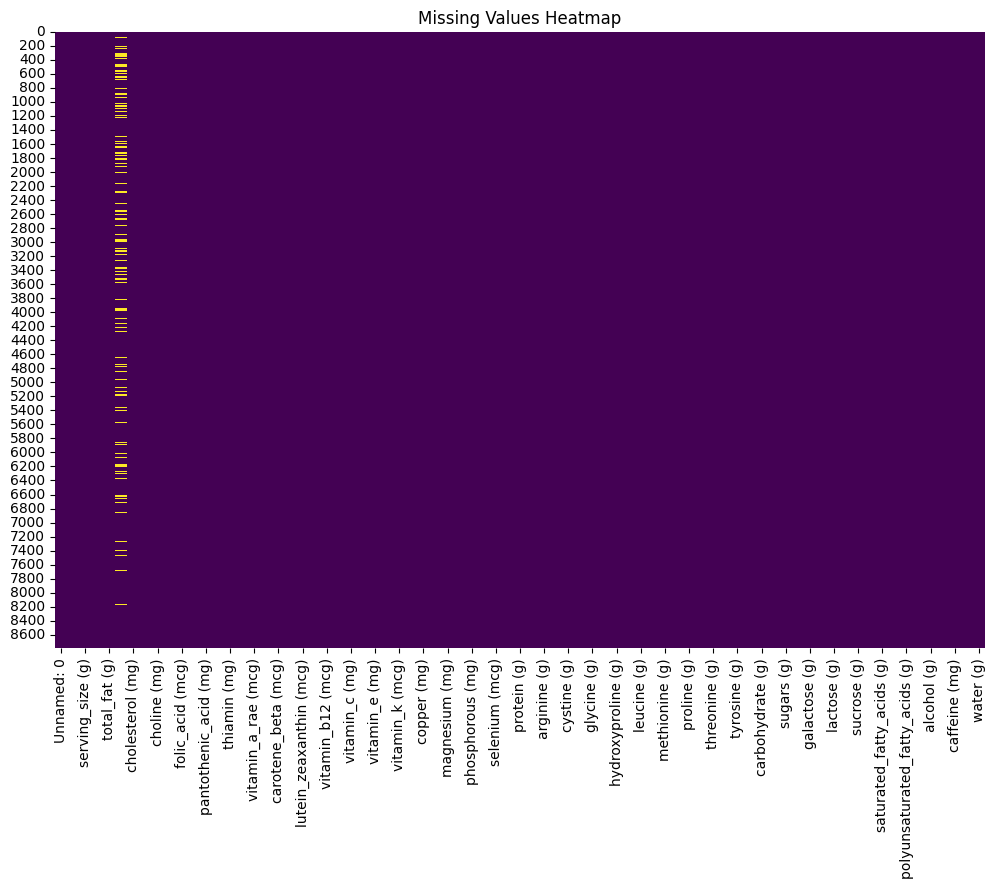

In [4]:
df_missing_values = df.isnull().sum()
df_missing_columns = df_missing_values[df_missing_values > 0]
print("Terdapat Data Yang Hilang Sebanyak ",df_missing_columns.count(), "Kolom, Dengan Nama Kolom : ")
print(df_missing_columns)
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()

### Check Data Missing Values (Replace the empty column in the column **saturated_fat** with the value **0**

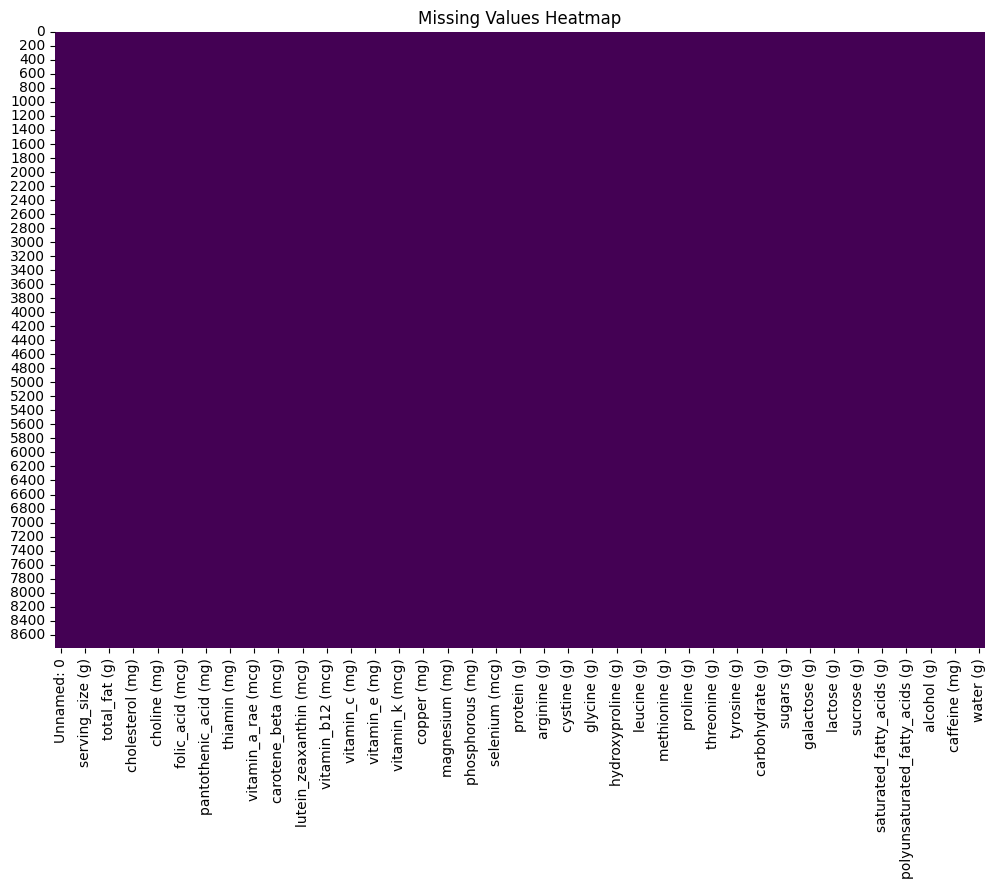

,Unnamed: 0,name,serving_size (g),calories,total_fat (g),saturated_fat (g),cholesterol (mg),sodium (mg),choline (mg),folate (mcg),...,fat (g),saturated_fatty_acids (g),monounsaturated_fatty_acids (g),polyunsaturated_fatty_acids (g),fatty_acids_total_trans (mg),alcohol (g),ash (g),caffeine (mg),theobromine (mg),water (g)
0,0,Cornstarch,100.0,381,0.1,0.0,0.0,9.0,0.4,0.0,...,0.05,0.009,0.016,0.025,0.0,0.0,0.09,0.0,0.0,8.32
1,1,"Nuts, pecans",100.0,691,72.0,6.2,0.0,0.0,40.5,22.0,...,71.97,6.180,40.801,21.614,0.0,0.0,1.49,0.0,0.0,3.52
2,2,"Eggplant, raw",100.0,25,0.2,0.0,0.0,2.0,6.9,22.0,...,0.18,0.034,0.016,0.076,0.0,0.0,0.66,0.0,0.0,92.30
3,3,"Teff, uncooked",100.0,367,2.4,0.4,0.0,12.0,13.1,0.0,...,2.38,0.449,0.589,1.071,0.0,0.0,2.37,0.0,0.0,8.82
4,4,"Sherbet, orange",100.0,144,2.0,1.2,1.0,46.0,7.7,4.0,...,2.00,1.160,0.530,0.080,1.0,0.0,0.40,0.0,0.0,66.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8784,8784,"Beef, raw, all grades, trimmed to 0"" fat, sepa...",100.0,125,3.5,1.4,62.0,54.0,64.5,4.0,...,3.50,1.353,1.554,0.244,62.0,0.0,1.11,0.0,0.0,72.51
8785,8785,"Lamb, cooked, separable lean only, composite o...",100.0,206,8.9,3.9,109.0,50.0,0.0,0.0,...,8.86,3.860,3.480,0.520,109.0,0.0,1.60,0.0,0.0,59.95
8786,8786,"Lamb, raw, separable lean and fat, composite o...",100.0,277,23.0,12.0,78.0,39.0,0.0,1.0,...,22.74,11.570,8.720,0.980,78.0,0.0,0.92,0.0,0.0,59.80
8787,8787,"Beef, raw, all grades, trimmed to 0"" fat, sepa...",100.0,121,3.0,1.1,60.0,53.0,64.2,4.0,...,3.04,1.086,1.266,0.233,60.0,0.0,1.10,0.0,0.0,73.43


In [5]:
# Ganti NaN dengan 0 pada Seluruh DataFrame
df.fillna(0, inplace=True)
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values Heatmap")
plt.show()
df

### Menyimpan DataFrame yang sudah dibersihkan ke file CSV

In [6]:
# Menghapus kolom yang mengandung "Unnamed"
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Mengubah nama kolom "iron" menjadi "iron" jika kolom tersebut ada
if 'irom (mg)' in df.columns:
    df.rename(columns={'irom (mg)': 'iron (mg)'}, inplace=True)
    print("Kolom 'irom (mg)' telah diubah menjadi 'iron (mg)'.")

# Menyimpan DataFrame yang sudah dibersihkan ke file CSV
output_file = r'..\data\Food\cleaned_data_nutrition.csv'
df.to_csv(output_file, index=False)
print(f"\nData yang sudah dibersihkan telah disimpan ke '{output_file}'")

C:\Users\HP\AppData\Local\Temp\ipykernel_10776\2396909377.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'irom (mg)': 'iron (mg)'}, inplace=True)


Kolom 'irom (mg)' telah diubah menjadi 'iron (mg)'.

Data yang sudah dibersihkan telah disimpan ke '..\data\Food\cleaned_data_nutrition.csv'


## Distribution of Key Nutrients (Histogram)

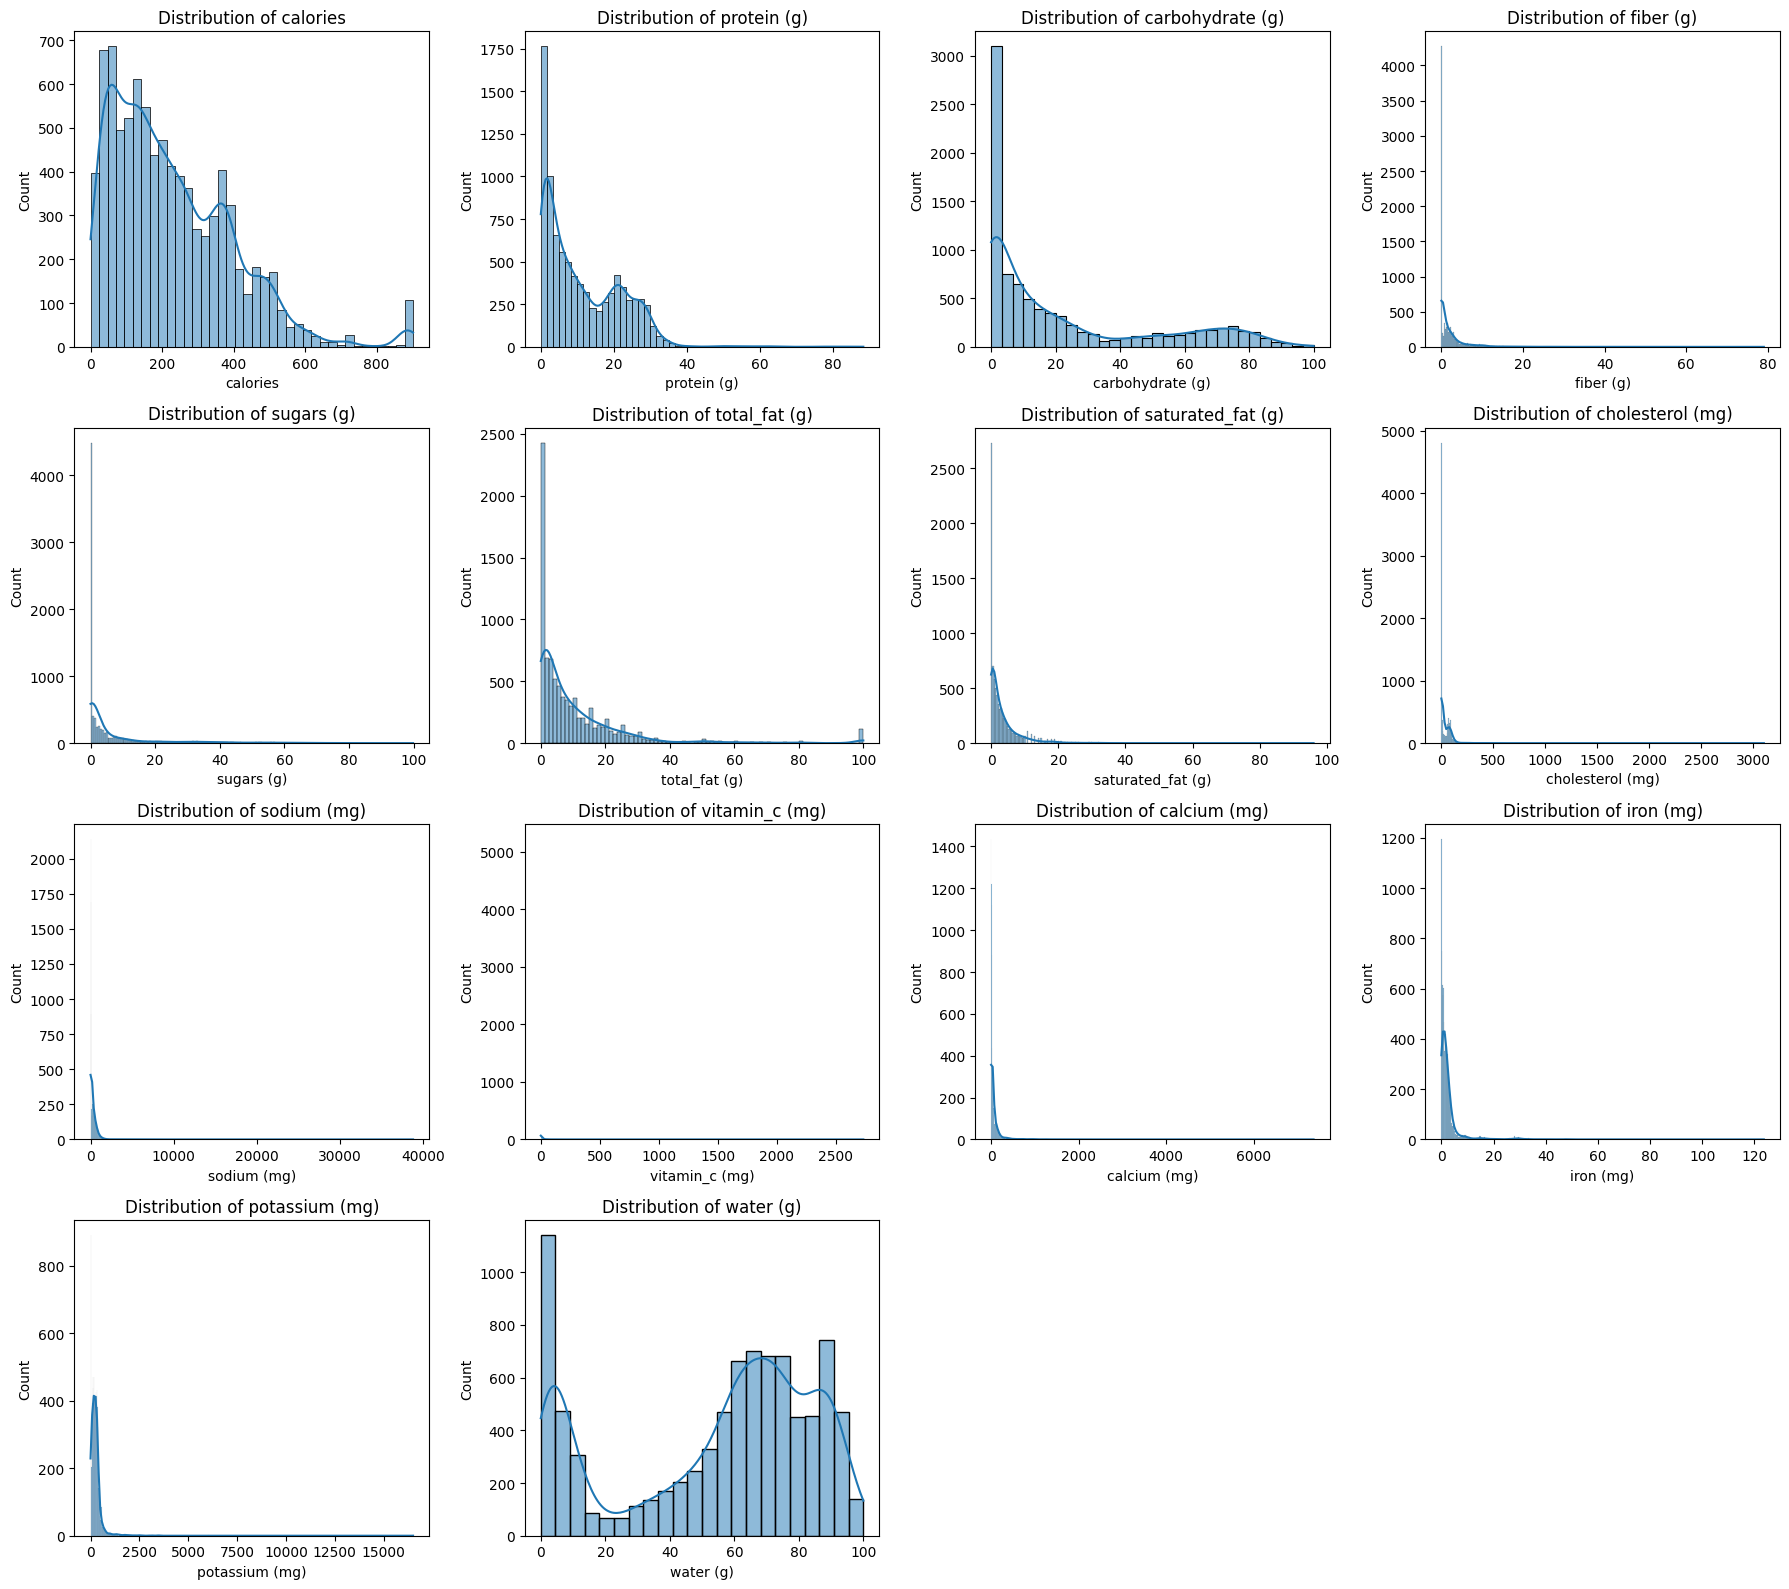

In [7]:
# List of key nutrient columns for distribution analysis
selected_columns = ['calories', 'protein (g)', 'carbohydrate (g)', 'fiber (g)', 'sugars (g)', 
                    'total_fat (g)', 'saturated_fat (g)', 'cholesterol (mg)', 'sodium (mg)', 
                    'vitamin_c (mg)', 'calcium (mg)', 'iron (mg)', 'potassium (mg)', 'water (g)']

# Set up a larger grid to visualize these columns
rows = (len(selected_columns) // 4) + 1

plt.figure(figsize=(18, 4 * rows))

for i, col in enumerate(selected_columns, 1):
    plt.subplot(rows, 4, i)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()

plt.show()

## Boxplot to Detect Outliers

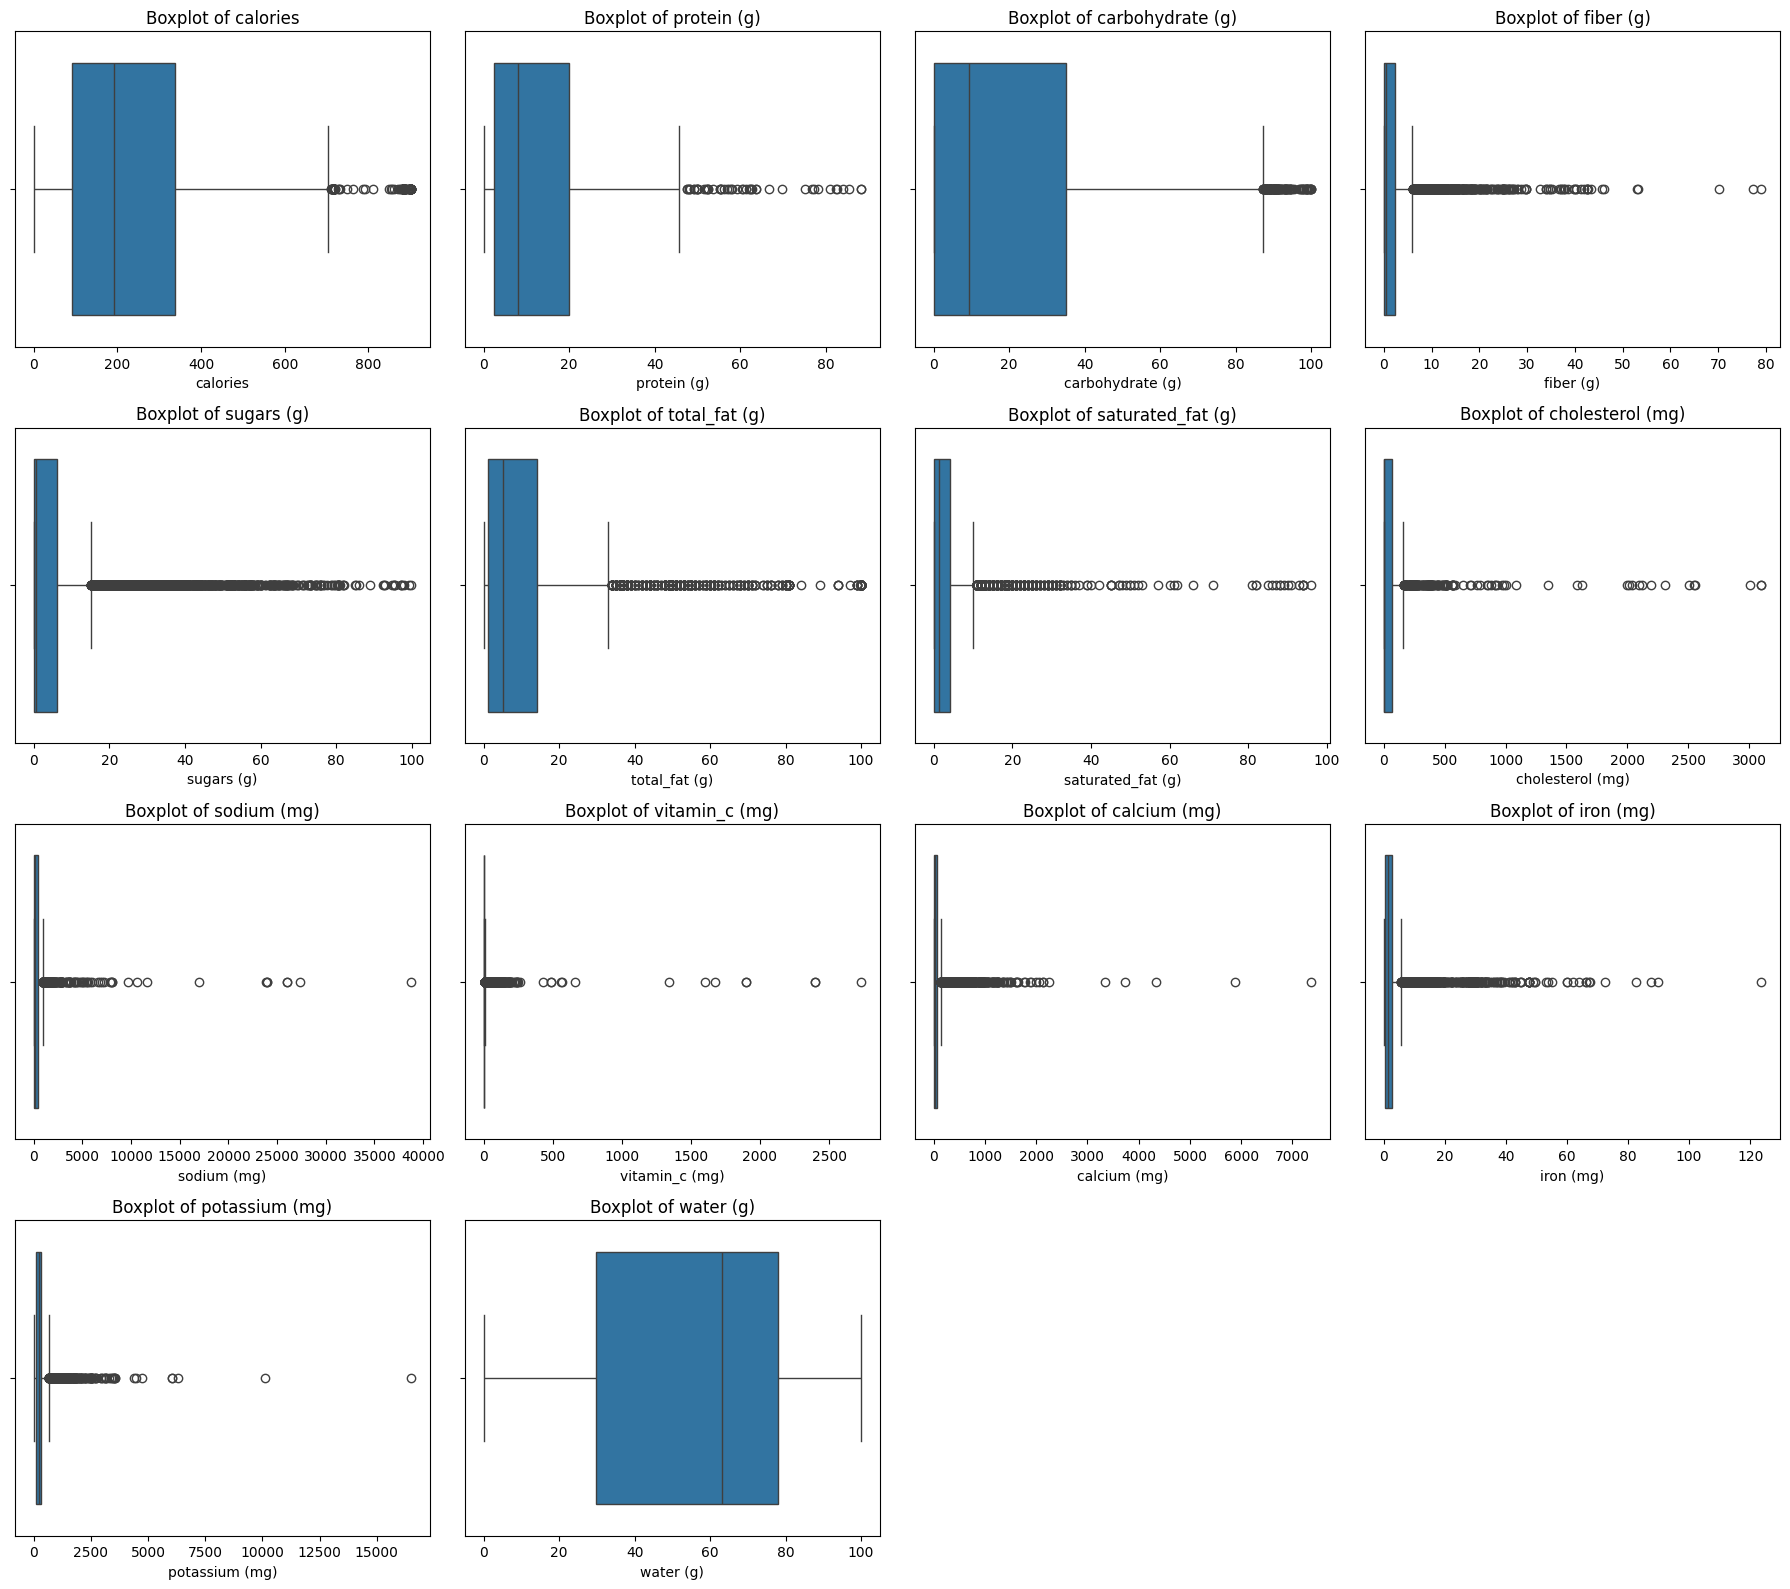

In [8]:
# Boxplot to detect outliers
plt.figure(figsize=(18, 4 * rows))

for i, col in enumerate(selected_columns, 1):
    plt.subplot(rows, 4, i)
    sns.boxplot(x=df[col].dropna())
    plt.title(f"Boxplot of {col}")
    plt.xlabel(col)
    plt.tight_layout()

plt.show()


## Correlation Heatmap

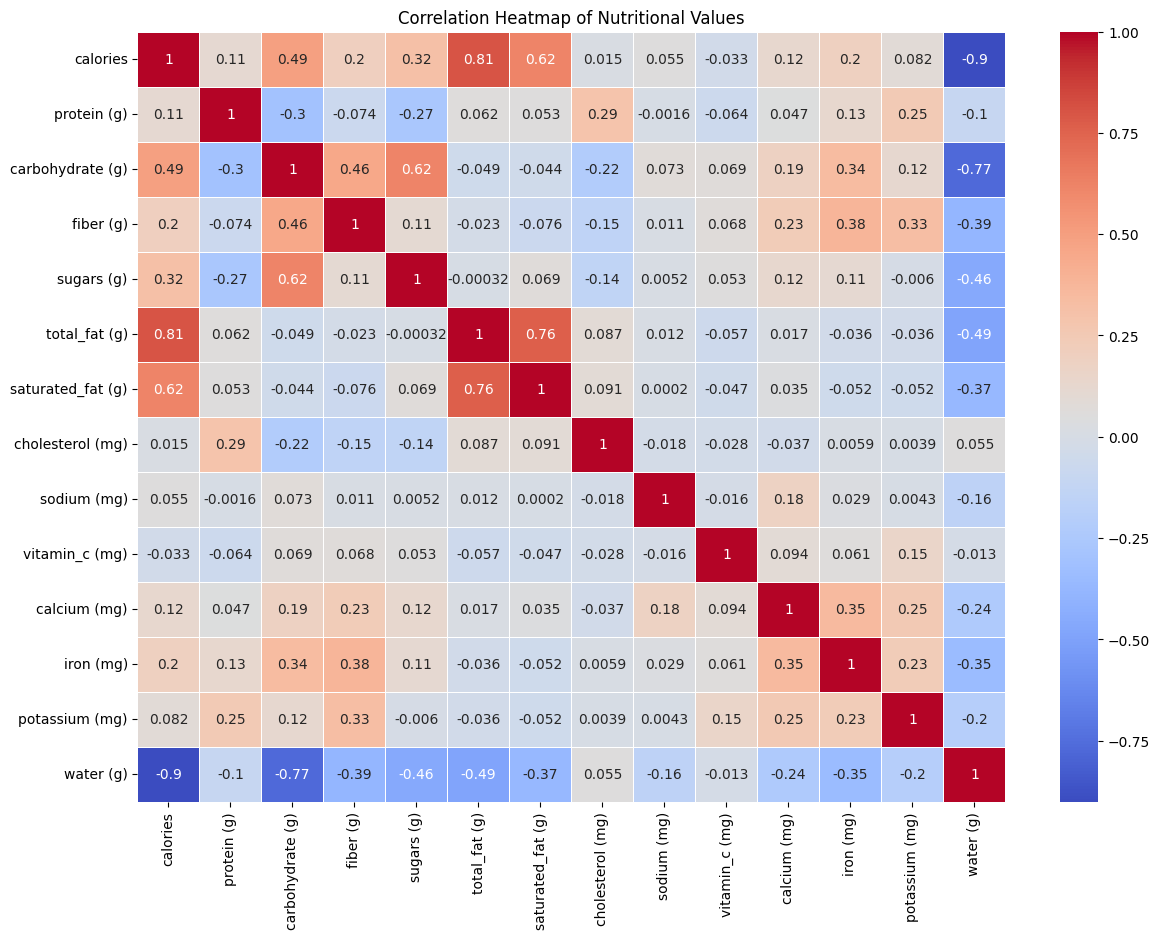

In [9]:
plt.figure(figsize=(14, 10))
correlation_matrix = df[selected_columns].corr()

# Generate heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Heatmap of Nutritional Values")
plt.show()

## Comparison of Macronutrients

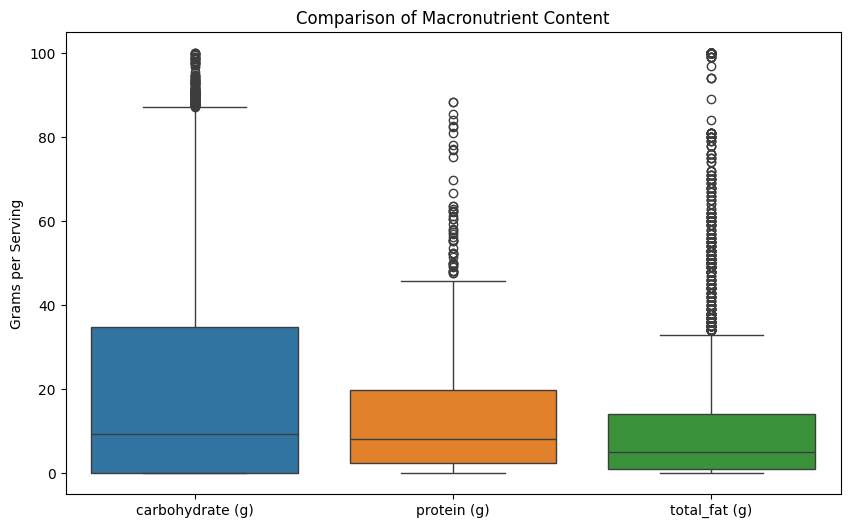

In [10]:
macronutrients = ['carbohydrate (g)', 'protein (g)', 'total_fat (g)']

plt.figure(figsize=(10, 6))
sns.boxplot(data=df[macronutrients])
plt.title("Comparison of Macronutrient Content")
plt.ylabel("Grams per Serving")
plt.show()

## Top High-Protein Foods

C:\Users\HP\AppData\Local\Temp\ipykernel_10776\603136563.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='protein (g)', y='name', data=top_protein, palette='viridis')


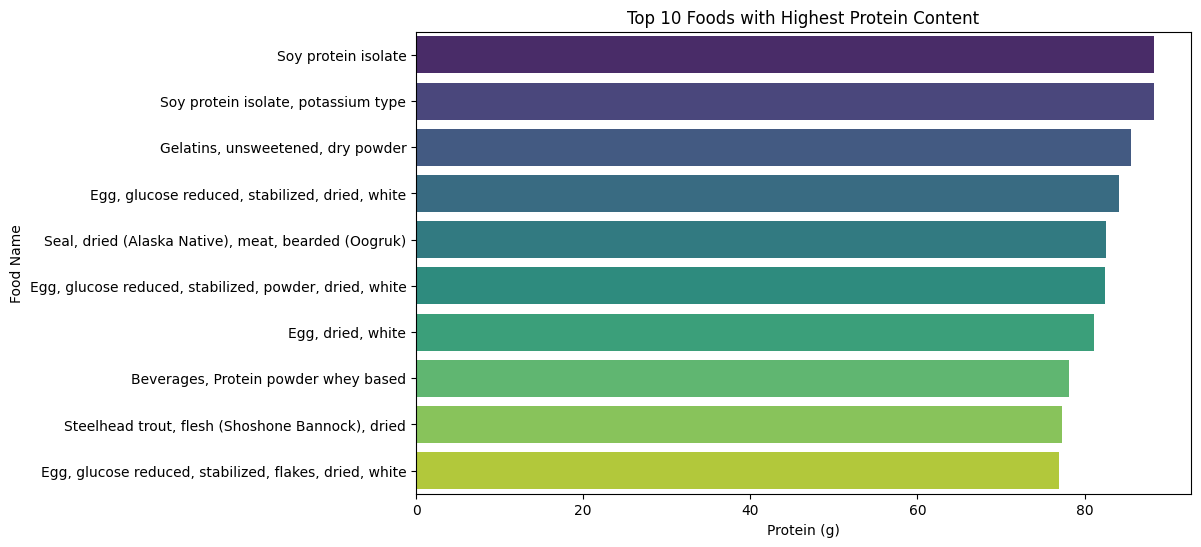

In [11]:
# Sort by protein content and plot top 10 foods
top_protein = df[['name', 'protein (g)']].sort_values(by='protein (g)', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='protein (g)', y='name', data=top_protein, palette='viridis')
plt.title("Top 10 Foods with Highest Protein Content")
plt.xlabel("Protein (g)")
plt.ylabel("Food Name")
plt.show()

## Top Low-Calorie Foods

C:\Users\HP\AppData\Local\Temp\ipykernel_10776\3643728723.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='calories', y='name', data=low_calories, palette='Blues')


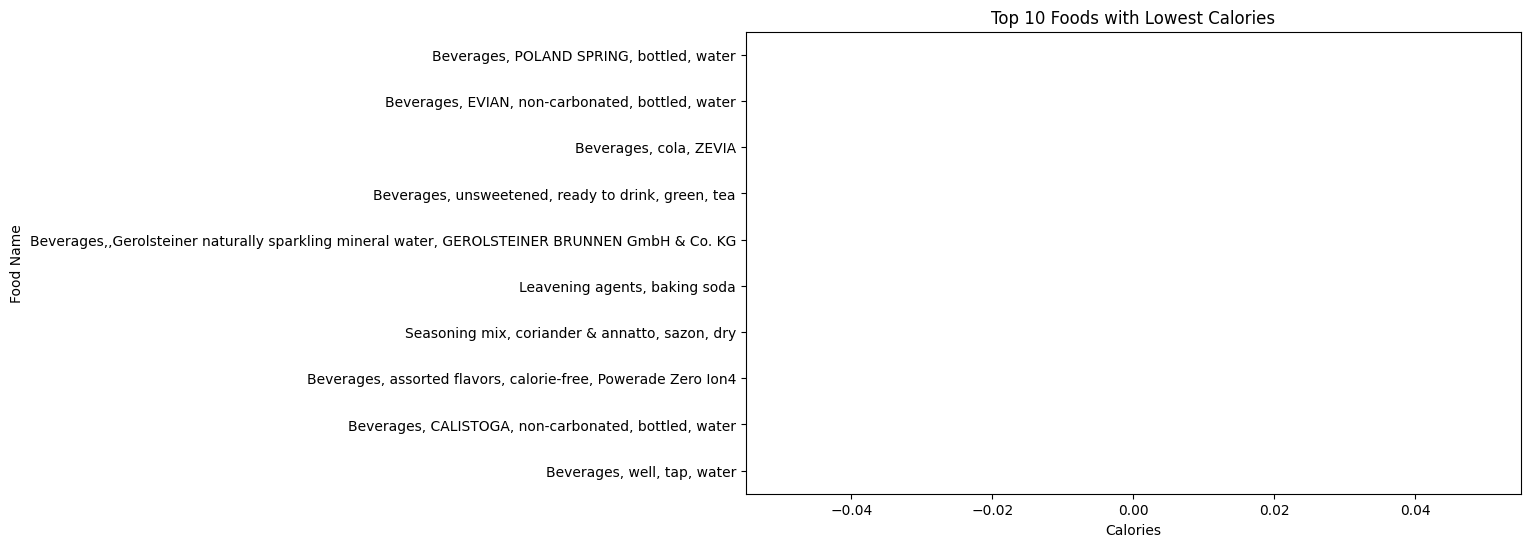

In [12]:
# Sort by calories and plot top 10 lowest-calorie foods
low_calories = df[['name', 'calories']].sort_values(by='calories', ascending=True).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='calories', y='name', data=low_calories, palette='Blues')
plt.title("Top 10 Foods with Lowest Calories")
plt.xlabel("Calories")
plt.ylabel("Food Name")
plt.show()

## Visualize distribution of calories

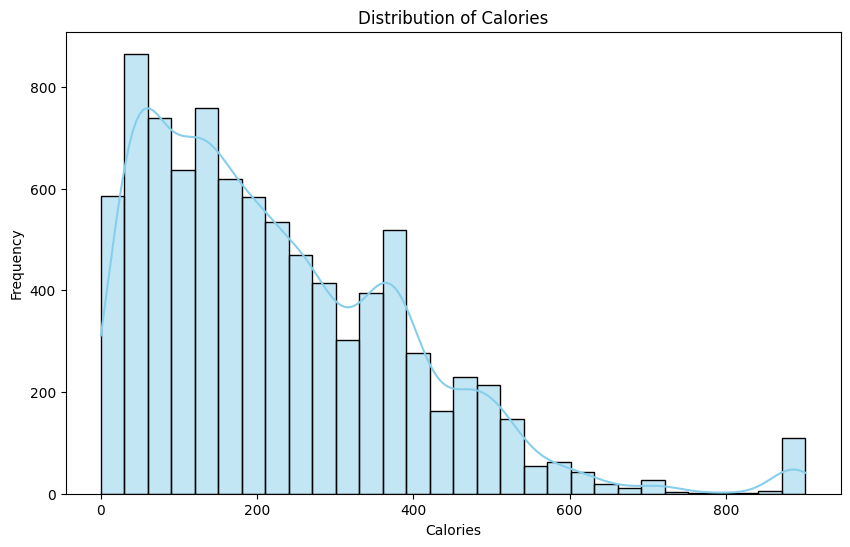

In [13]:
plt.figure(figsize=(10, 6))
sns.histplot(df['calories'], kde=True, bins=30, color='skyblue')
plt.title('Distribution of Calories')
plt.xlabel('Calories')
plt.ylabel('Frequency')
plt.show()

## Visualize the distribution of serving sizes

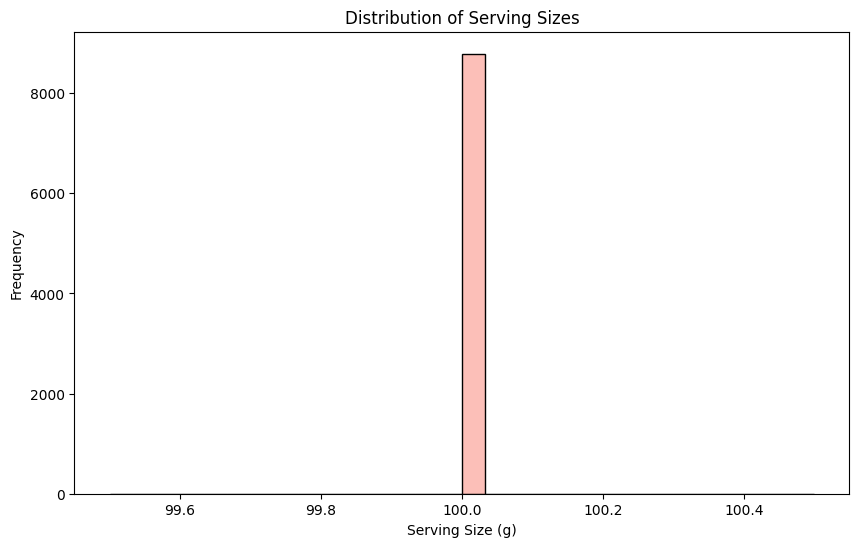

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(df['serving_size (g)'], kde=True, bins=30, color='salmon')
plt.title('Distribution of Serving Sizes')
plt.xlabel('Serving Size (g)')
plt.ylabel('Frequency')
plt.show()

## Top 10 foods with the highest calories

In [15]:
top_calories = df[['name', 'calories']].sort_values(by='calories', ascending=False).head(10)
print("\nTop 10 Foods with the Highest Calories:")
print(top_calories)


Top 10 Foods with the Highest Calories:
                                        name  calories
318                       Fat, mutton tallow       902
422                         Fish oil, salmon       902
676                                     Lard       902
430                         Fat, beef tallow       902
256                      Fish oil, cod liver       902
2253  Fish oil, fully hydrogenated, menhaden       902
293                       Fish oil, menhaden       902
355                        Fish oil, sardine       902
356                        Fish oil, herring       902
642                               Fat, goose       900


## Top 10 foods with the highest protein content

In [16]:
top_protein = df[['name', 'protein (g)']].sort_values(by='protein (g)', ascending=False).head(10)
print("\nTop 10 Foods with the Highest Protein Content:")
print(top_protein)


Top 10 Foods with the Highest Protein Content:
                                                   name  protein (g)
213                                 Soy protein isolate        88.32
1378                Soy protein isolate, potassium type        88.32
1618                  Gelatins, unsweetened, dry powder        85.60
3893     Egg, glucose reduced, stabilized, dried, white        84.08
4401  Seal, dried (Alaska Native), meat, bearded (Oo...        82.60
5357  Egg, glucose reduced, stabilized, powder, drie...        82.40
389                                   Egg, dried, white        81.10
2476               Beverages, Protein powder whey based        78.13
3546   Steelhead trout, flesh (Shoshone Bannock), dried        77.27
5356  Egg, glucose reduced, stabilized, flakes, drie...        76.92


## Visualizing nutrient content

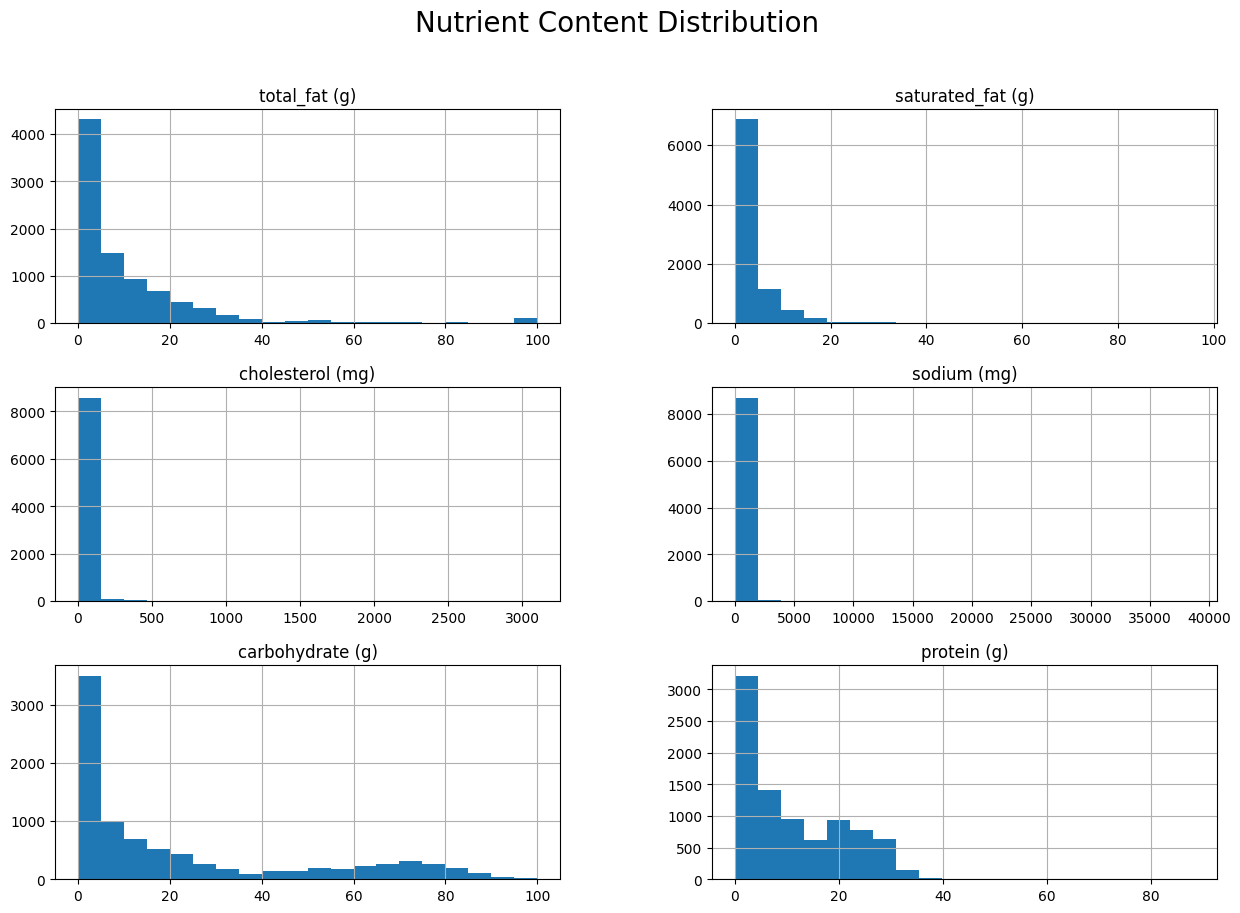

In [17]:
nutrients = ['total_fat (g)', 'saturated_fat (g)', 'cholesterol (mg)', 'sodium (mg)', 'carbohydrate (g)', 'protein (g)']
df[nutrients].hist(figsize=(15, 10), bins=20)
plt.suptitle('Nutrient Content Distribution', fontsize=20)
plt.show()

## Pairplot to analyze relationships between various nutrients

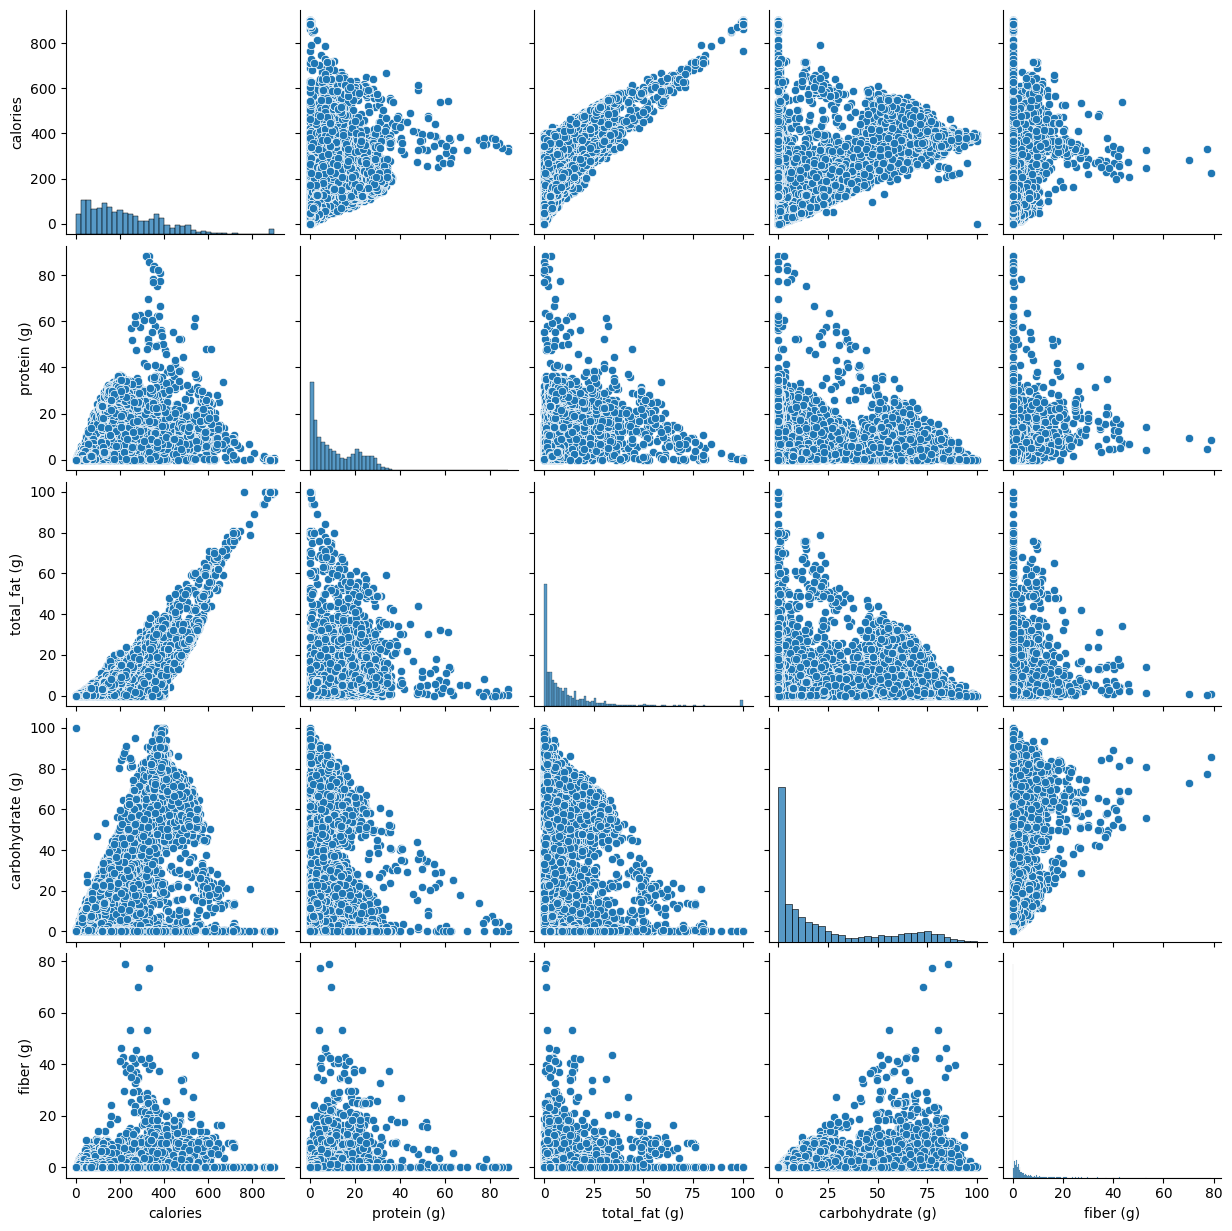

In [18]:
sns.pairplot(df[['calories', 'protein (g)', 'total_fat (g)', 'carbohydrate (g)', 'fiber (g)']])
plt.show()

## Scatter plot of calories vs protein content

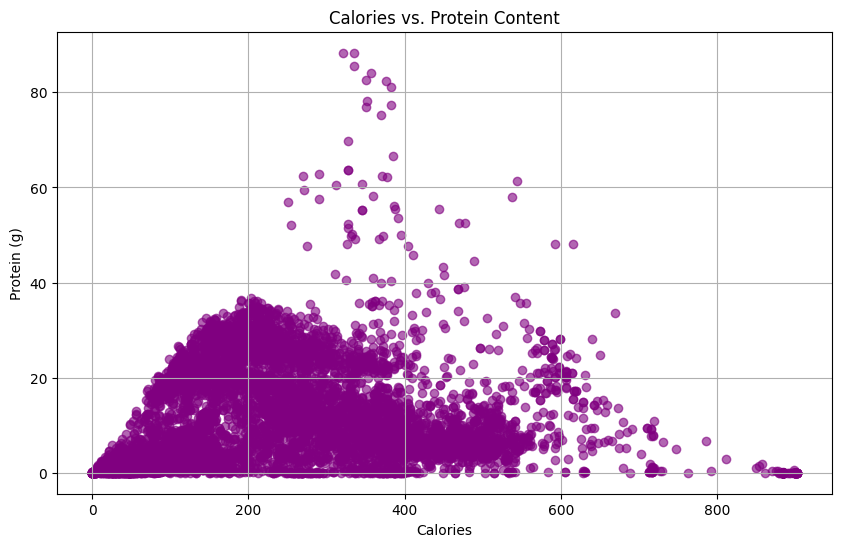

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(df['calories'], df['protein (g)'], alpha=0.6, color='purple')
plt.title('Calories vs. Protein Content')
plt.xlabel('Calories')
plt.ylabel('Protein (g)')
plt.grid(True)
plt.show()

## Stacked Bar Chart: Proportion of Nutrients in Recipes

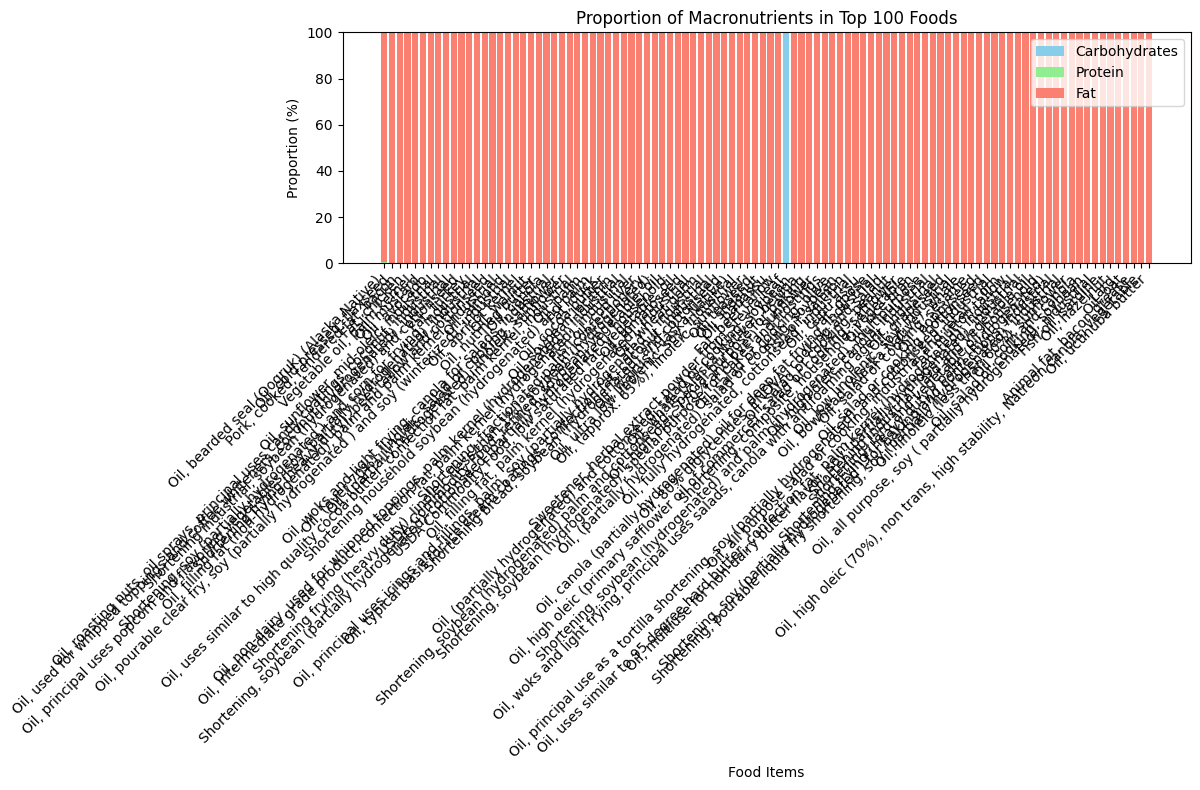

In [20]:
# Select key columns for macronutrients analysis
macronutrient_cols = ['name', 'carbohydrate (g)', 'protein (g)', 'total_fat (g)']

# Filter dataset to include only relevant columns
df_macronutrients = df[macronutrient_cols].dropna()

# Normalize the macronutrient values to show proportions
df_macronutrients['total'] = df_macronutrients[['carbohydrate (g)', 'protein (g)', 'total_fat (g)']].sum(axis=1)
df_macronutrients['carbohydrate (%)'] = (df_macronutrients['carbohydrate (g)'] / df_macronutrients['total']) * 100
df_macronutrients['protein (%)'] = (df_macronutrients['protein (g)'] / df_macronutrients['total']) * 100
df_macronutrients['fat (%)'] = (df_macronutrients['total_fat (g)'] / df_macronutrients['total']) * 100

# Sort by total content and take top 10 for visualization
top_10 = df_macronutrients.sort_values(by='total', ascending=False).head(100)

# Plotting the stacked bar chart
plt.figure(figsize=(12, 8))
plt.bar(top_10['name'], top_10['carbohydrate (%)'], label='Carbohydrates', color='skyblue')
plt.bar(top_10['name'], top_10['protein (%)'], bottom=top_10['carbohydrate (%)'], label='Protein', color='lightgreen')
plt.bar(top_10['name'], top_10['fat (%)'], 
        bottom=top_10['carbohydrate (%)'] + top_10['protein (%)'], label='Fat', color='salmon')

plt.title("Proportion of Macronutrients in Top 100 Foods")
plt.xlabel("Food Items")
plt.ylabel("Proportion (%)")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

## Average Nutrient Composition Across All Recipes

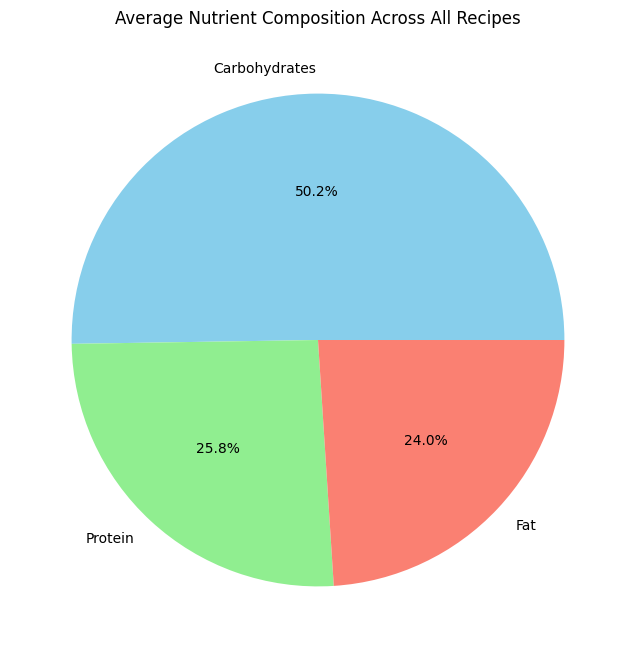

In [21]:
# Calculate average proportion of macronutrients across the entire dataset
avg_carbs = df_macronutrients['carbohydrate (g)'].sum()
avg_protein = df_macronutrients['protein (g)'].sum()
avg_fat = df_macronutrients['total_fat (g)'].sum()
total = avg_carbs + avg_protein + avg_fat

# Calculate the percentage of each nutrient
macronutrient_distribution = {
    'Carbohydrates': (avg_carbs / total) * 100,
    'Protein': (avg_protein / total) * 100,
    'Fat': (avg_fat / total) * 100
}

# Pie chart visualization
plt.figure(figsize=(8, 8))
plt.pie(macronutrient_distribution.values(), labels=macronutrient_distribution.keys(), 
        autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'salmon'])
plt.title("Average Nutrient Composition Across All Recipes")
plt.show()

## WordCloud for food names

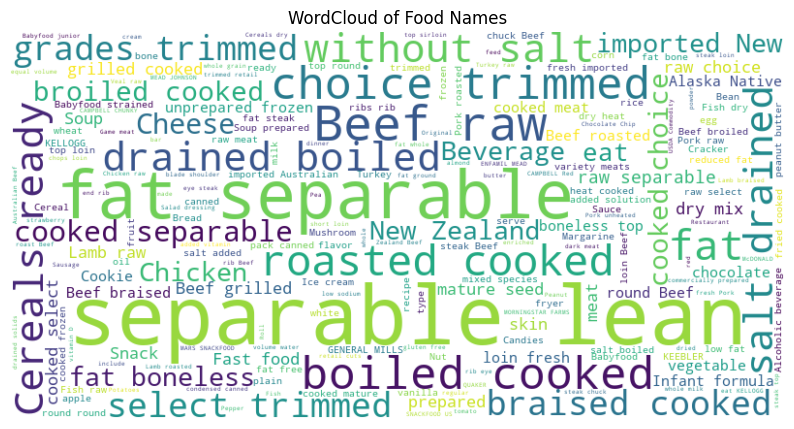

In [22]:
text = " ".join(food for food in df['name'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud of Food Names')
plt.show()